<a href="https://colab.research.google.com/github/marketakvasova/LSEC_segmentation/blob/main/LSEC_fenestration_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Automatic segmentation of electron microscope images**
---

This notebook is intended for using a neural network for the task of binary segmentation of fenestrations of Liver sinusoidal entdothelial cells (LSECs).

# How to use this notebook
---

This notebook works with data saved on your Google Drive.

In [1]:
# @title  { display-mode: "form" }
#@markdown ##**Run this cell to connect to Google Drive**
#@markdown A new window will open where you will be able to connect.

#@markdown When you are connected, you can see your Drive content in the left sidebar under **Files**.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# 1. Setup
---

In [ ]:
# @title  { display-mode: "form" }
#@markdown ##**Import necessary libraries**
!python --version
# !pip install wandb
!pip install torchmetrics
!pip install segmentation-models-pytorch

import segmentation_models_pytorch as smp
from torchmetrics.classification import Dice, BinaryJaccardIndex
import os
from google.colab import drive
import torch.cuda
from torch.utils.data import Dataset
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.optim as optim
# from torchsummary import summary
import shutil
import cv2 as cv
from numpy.lib.stride_tricks import as_strided
import pywt
from scipy.stats import norm
from google.colab.patches import cv2_imshow
import gc
# import wandb
# from numba import njit
# from scipy.signal import convolve2d
import math

# gc.collect()
drive.mount('/content/gdrive')
# model_folder = "./gdrive/MyDrive/ROI_patches/my_model"
# os.makedirs(model_folder, exist_ok=True)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # TODO: do not even try this, if the gpu is not connected
# print(DEVICE)
# biomodel_folder = os.path.join(model_folder, "bioimageio_model")
# biomodel_path = os.path.join(biomodel_folder, "weights.pt")
# os.makedirs(biomodel_folder, exist_ok=True)
# LOAD_TRAINED_MODEL = False
# model_path = os.path.join(model_folder,"my_checkpoint.pth.tar")

Python 3.10.12
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 11.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylin

# Load necessary functions
---

## Data utils

In [ ]:
class MyDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted([f for f in os.listdir(self.image_dir) if os.path.isfile(os.path.join(self.image_dir, f))])
        self.masks = sorted([f for f in os.listdir(self.mask_dir) if os.path.isfile(os.path.join(self.mask_dir, f))])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index]) # mask and image need to be called the same
        image = cv.imread(img_path, cv.IMREAD_GRAYSCALE).astype(np.float32)
        mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE).astype(np.float32)
        # mask /= 255
        mask[mask == 255.0] = 1

        augmentations = self.transform(image=image, mask=mask)
        image = augmentations["image"]
        mask = augmentations["mask"]

        return image, mask

def normalize_hist(img):
    clahe = cv.createCLAHE(10, tileGridSize=(11, 11))
    img = clahe.apply(img)
    img = cv.medianBlur(img, 3)
    return img

def get_loaders(img_train, mask_train, img_val, mask_val, batch_size, num_workers=0, pin_memory=True):
    train_transform, val_transform = get_transforms()

    train_data = MyDataset(
        image_dir=img_train,
        mask_dir=mask_train,
        transform=train_transform
    )
    val_data = MyDataset(
        image_dir=img_val,
        mask_dir=mask_val,
        transform=val_transform
    )

    train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True
    )

    val_loader = DataLoader(
        val_data,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False
    )

    return train_loader, val_loader


test_transform = A.Compose(
    [
        A.Normalize(
        mean = 0.5,
        std = 0.5,
        max_pixel_value=255.0,
        ),
            ToTensorV2()
    ]
)

def merge_images(image, mask):
    merge = np.zeros((mask.shape[0], mask.shape[1], 3))
    merge[:, :, 0] = image # B channel (0, 1, 2) = (B, G, R)
    merge[:, :, 2] = image # R channel
    merge[:, :, 1] = mask # G channel
    merge[:, :, 2][mask == 255.0] = 255 # R channel
    merge = merge.astype('uint8')
    return merge


def merge_original_mask(image_path, mask_path, output_folder):
    image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
    merge = merge_images(image, mask)
    filename_ext = os.path.basename(image_path)
    filename, ext = os.path.splitext(filename_ext)
    cv.imwrite(os.path.join(output_folder, filename+"_original_mask_merge"+ext), merge)


def merge_masks(mask1_path, mask2_path, output_folder):
    mask1 = cv.imread(mask1_path, cv.IMREAD_GRAYSCALE)
    mask2 = cv.imread(mask2_path, cv.IMREAD_GRAYSCALE)
    # merge = merge_images(image, mask)
    merge = np.zeros((mask1.shape[0], mask1.shape[1], 3))

    merge[:, :, 1][mask1 == 255.0] = 255
    merge[:, :, 2][mask2 == 255.0] = 255

    filename_ext = os.path.basename(mask1_path)
    filename, ext = os.path.splitext(filename_ext)
    cv.imwrite(os.path.join(output_folder, filename+"_mask_compare"+ext), merge)


def create_weighting_patches(patch_size, edge_size):
    patch = np.ones((patch_size, patch_size), dtype=float)

    # Calculate the linear decrease values
    decrease_values = np.linspace(1, 0, num=edge_size)
    decrease_values = np.tile(decrease_values, (patch_size, 1))
    increase_values = np.linspace(0, 1, num=edge_size)
    increase_values = np.tile(increase_values, (patch_size, 1))

    # Middle patch
    # Apply linear decrease to all four edges
    middle = patch.copy()
    middle[:, 0:edge_size] *= increase_values
    middle[:, patch_size-edge_size:patch_size] *= decrease_values
    middle[0:edge_size, :] *= increase_values.T
    middle[patch_size-edge_size:patch_size, :] *= decrease_values.T
    # cv2_imshow((middle*255).astype(np.uint8))

    # Left
    left = patch.copy()
    left[:, patch_size-edge_size:patch_size] *= decrease_values
    left[0:edge_size, :] *= increase_values.T
    left[patch_size-edge_size:patch_size, :] *= decrease_values.T
    # cv2_imshow((left*255).astype(np.uint8))

    # Right
    right = patch.copy()
    right[:, 0:edge_size] *= increase_values
    right[0:edge_size, :] *= increase_values.T
    right[patch_size-edge_size:patch_size, :] *= decrease_values.T
    # cv2_imshow((right*255).astype(np.uint8))

    # Top
    top = patch.copy()
    top[:, 0:edge_size] *= increase_values
    top[:, patch_size-edge_size:patch_size] *= decrease_values
    top[patch_size-edge_size:patch_size, :] *= decrease_values.T
    # cv2_imshow((top*255).astype(np.uint8))

    # Bottom
    bottom = patch.copy()
    bottom[:, 0:edge_size] *= increase_values
    bottom[:, patch_size-edge_size:patch_size] *= decrease_values
    bottom[0:edge_size, :] *= increase_values.T
    # cv2_imshow((bottom*255).astype(np.uint8))

    # Left Top edge
    top_left = patch.copy()
    top_left[:, patch_size-edge_size:patch_size] *= decrease_values
    top_left[patch_size-edge_size:patch_size, :] *= decrease_values.T
    # cv2_imshow((top_left*255).astype(np.uint8))

    # Right top edge
    top_right = patch.copy()
    top_right[:, 0:edge_size] *= increase_values
    top_right[patch_size-edge_size:patch_size, :] *= decrease_values.T
    # cv2_imshow((top_right*255).astype(np.uint8))

    # Left bottom edge
    bottom_left = patch.copy()
    bottom_left[:, patch_size-edge_size:patch_size] *= decrease_values
    bottom_left[0:edge_size, :] *= increase_values.T
    # cv2_imshow((bottom_left*255).astype(np.uint8))

    # Right Bottom edge
    bottom_right = patch.copy()
    bottom_right[:, 0:edge_size] *= increase_values
    bottom_right[0:edge_size, :] *= increase_values.T
    # cv2_imshow((bottom_right*255).astype(np.uint8))

    return middle, top_left, top, top_right, right, bottom_right, bottom, bottom_left, left


def add_mirrored_border(image, border_size, window_size):
    height, width = image.shape

    bottom_edge = window_size - ((height + border_size) % (window_size - border_size))
    right_edge = window_size - ((width + border_size) % (window_size - border_size))

    top_border = np.flipud(image[0:border_size, :])
    bottom_border = np.flipud(image[height - (border_size+bottom_edge):height, :])
    top_bottom_mirrored = np.vstack((top_border, image, bottom_border))

    left_border = np.fliplr(top_bottom_mirrored[:, 0:border_size])
    right_border = np.fliplr(top_bottom_mirrored[:, width - (border_size+right_edge):width])
    mirrored_image = np.hstack((left_border, top_bottom_mirrored, right_border))
    return mirrored_image

def inference_on_image_with_overlap(model, image_path):
    window_size = 224
    oh, ow = 20, 20

    input_image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    image_height, image_width = input_image.shape
    original_height, original_width = image_height, image_width


    mirrored_image = add_mirrored_border(input_image, oh, window_size)
    image_height, image_width = mirrored_image.shape


    weights = np.zeros((image_height, image_width))
    output_probs = np.zeros((image_height, image_width))
    output_mask = np.zeros((image_height, image_width))
    middle, top_left, top, top_right, right, bottom_right, bottom, bottom_left, left = create_weighting_patches(window_size, oh)

    for x in range(0, image_height-window_size+1, window_size - oh):
        for y in range(0, image_width-window_size+1, window_size - ow):
            # Choose weighting window

            if x == 0:
                if y == 0:
                    weighting_window = top_left
                elif y == image_width - window_size:
                    weighting_window = top_right
                else:
                    weighting_window = top
            elif x == image_height - window_size:
                if y == 0:
                    weighting_window = bottom_left
                elif y == image_width - window_size:
                    weighting_window = bottom_right
                else:
                    weighting_window = bottom
            elif y == 0:
                weighting_window = left
            elif y == image_width - window_size:
                weighting_window = right
            else:
                weighting_window = middle
            square_section = mirrored_image[x:x + window_size, y:y + window_size]
            weights[x:x + window_size, y:y + window_size] += weighting_window
            square_section = normalize_hist(square_section)
            square_tensor = test_transform(image=square_section)['image'].unsqueeze(0).to(DEVICE)  # Add batch and channel dimension

            with torch.no_grad():
                output = torch.sigmoid(model(square_tensor)).float()

            # Scale the probablity to 0-255
            output = output*255
            output_pil = output.squeeze(0).cpu().numpy().squeeze()
            output_probs[x:x+window_size, y:y+window_size] += output_pil*weighting_window

    output_probs = output_probs[oh:original_height+oh, ow:original_width+ow]
    weights *= 255

    threshold = int(255*0.4)
    output_mask = np.where(output_probs > threshold, 255, 0)
    output_mask = output_mask.astype(np.uint8)
    return output_mask

def build_model(model_name):
    in_channels = 1
    out_channels = 1
    model = smp.Unet(
            encoder_name=model_name,
            encoder_weights=None,
            in_channels=in_channels,
            classes=out_channels,
            activation=None,).to(DEVICE)
    return model

## Debug

53.59042354038966
652.4801269358426
Number of fenestrations: 2984
Number of fitted ellipses: 2984


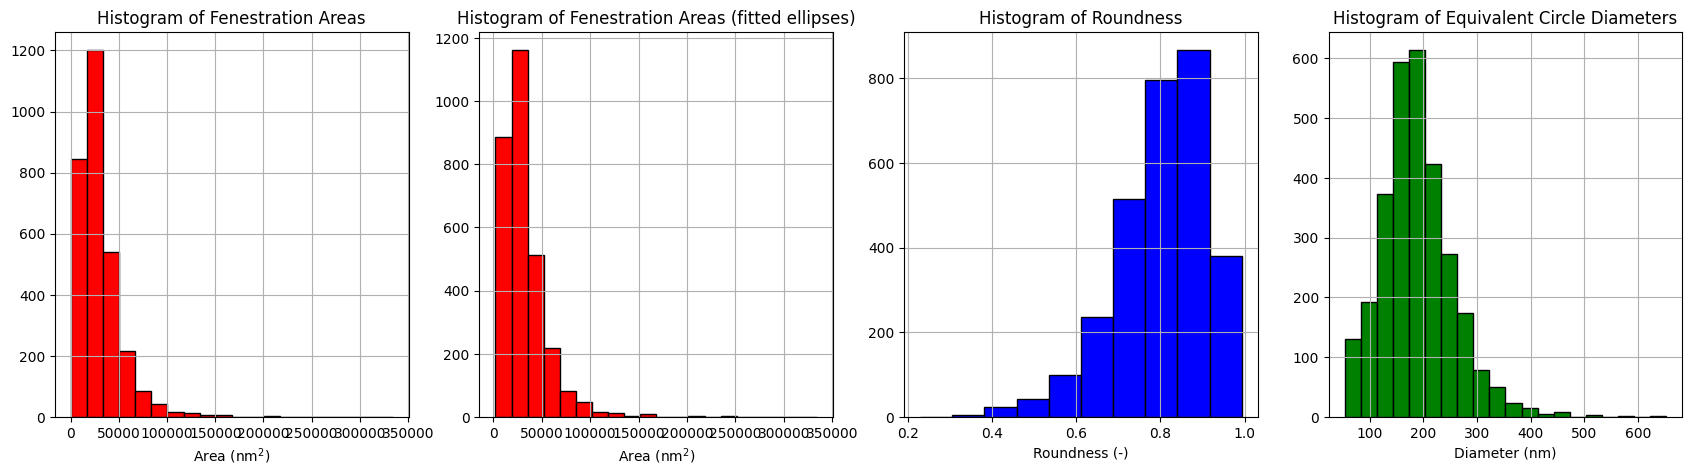

In [ ]:
from matplotlib.ticker import PercentFormatter

def show_fitted_ellipses(image_path, ellipses):
    image = cv.imread(image_path)
    for ellipse in ellipses:
        if ellipse is not None:
            cv.ellipse(image, ellipse, (0, 0, 255), 1)
            center, axes, angle = ellipse
            center_x, center_y = center
            major_axis_length, minor_axis_length = axes
            rotation_angle = angle
            # print(center_x, center_y)
            cv.circle(image, (int(center_x), int(center_y)),radius=1, color=(0, 0, 255), thickness=-1)

    cv2_imshow(image)

def fit_ellipses(filtered_contours, centers):
    ellipses = []
    num_ellipses = 0
    for contour, cnt_center in zip(filtered_contours, centers):
        if len(contour) >= 5:  # Ellipse fitting requires at least 5 points
            ellipse = cv.fitEllipse(contour) # TODO: maybe try a different computation, if this does not work well on edges (probably ok)
            dist = cv.norm(cnt_center, ellipse[0])
            if dist < 20:
                ellipses.append(ellipse)
                num_ellipses += 1
            else:
                ellipses.append((None, None, None))
        else:
            ellipses.append((None, None, None))
    # print(len(filtered_contours), len(ellipses))
    return ellipses, num_ellipses

def find_fenestration_contours(image_path):
    seg_mask = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    contours, _ = cv.findContours(seg_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    return contours
    # image = cv.cvtColor(seg_mask, cv.COLOR_GRAY2RGB)
    # image_el = image.copy()
    # cv.drawContours(image, contours, -1, (0, 0, 255), 1)
    # cv2_imshow(image)

    # Remove noise and small artifacts
    # min_contour_area = 10
    # filtered_contours = [cnt for cnt in contours if cv.contourArea(cnt) > min_contour_area]
    # return filtered_contours

def find_contour_centers(contours):
    contour_centers = []
    for cnt in contours:
        M = cv.moments(cnt)
        center_x = int(M['m10'] / (M['m00'] + 1e-10))
        center_y = int(M['m01'] / (M['m00'] + 1e-10))
        contour_centers.append((center_x, center_y))
    return contour_centers

def equivalent_circle_diameter(major_axis_length, minor_axis_length):
    return math.sqrt(major_axis_length * minor_axis_length)


def show_statistics(fenestration_areas, fenestration_areas_from_ellipses, roundness_of_ellipses, equivalent_diameters, min_roundness=0, min_d=None, max_d=None):
    # palette = itertools.cycle(sns.color_palette())
    plt.figure(figsize=(21, 5))

    # Plot histogram of fenestration areas
    plt.subplot(1, 4, 1)
    # sns.histplot(fenestration_areas, stat='probability')
    plt.hist(fenestration_areas, bins=20, color='red', edgecolor='black')
    plt.title('Histogram of Fenestration Areas')
    plt.xlabel('Area ($\mathrm{nm}^2$)')
    # plt.ylabel('Frequency')
    plt.grid(True)

    # Plot histogram of areas of fitted elipses
    plt.subplot(1, 4, 2)
    # sns.histplot(fenestration_areas_from_ellipses, stat='probability', color=next(palette)) # this will be the first color (blue)
    plt.hist(fenestration_areas_from_ellipses, bins=20, color='red', edgecolor='black')
    plt.title('Histogram of Fenestration Areas (fitted ellipses)')
    plt.xlabel('Area ($\mathrm{nm}^2$)')
    # plt.ylabel('Frequency')
    plt.grid(True)

    # Plot histogram of roundness
    plt.subplot(1, 4, 3)
    # r = sns.histplot(roundness_of_ellipses, stat='probability', color=next(palette), binwidth=0.025)
    # r.set(xlim=(min_roundness, None))
    plt.hist(roundness_of_ellipses, bins=10, color='blue', edgecolor='black')
    plt.title('Histogram of Roundness')
    plt.xlabel('Roundness (-)')
    # plt.ylabel('Frequency')
    plt.grid(True)
    # print(np.array(roundness_of_ellipses).max())

    # Plot histogram of equivalent circle diameters
    plt.subplot(1, 4, 4)
    # d = sns.histplot(equivalent_diameters, stat='probability', color=next(palette), binwidth=10)
    # d.set(xlim=(0, max_d))
    plt.hist(equivalent_diameters, bins=20, color='green', edgecolor='black')
    plt.title('Histogram of Equivalent Circle Diameters')
    plt.xlabel('Diameter (nm)')
    # plt.ylabel('Frequency')
    plt.grid(True)


    # plt.gca().yaxis.set_major_formatter(PercentFormatter(1))



# Mask statistics debug
# One pixel corresponds to 10.62 nm
image_path = "./gdrive/MyDrive/ROIs_manually_corrected/augment_mask/_0_379.tif"
image_path = "./gdrive/MyDrive/lsecs/cropped_selections/masks/I_K_02_1_mask.tif" # Image from semiautomatic labeling


pixel_size_nm = 10.62
contours = find_fenestration_contours(image_path)
fenestration_areas = [cv.contourArea(cnt) * (pixel_size_nm**2) for cnt in contours]
contour_centers = find_contour_centers(contours)
ellipses = fit_ellipses(contours, contour_centers)
# print(ellipses)
# Show image of fitted ellipses
# show_fitted_ellipses(image_path, ellipses)

roundness_of_ellipses = []
equivalent_diameters = []
fenestration_areas_from_ellipses = []

for ellipse in ellipses:
    if ellipse is not None:
        # print(ellipse)
        center, axes, angle = ellipse
        # center_x, center_y = center
        minor_axis_length, major_axis_length = axes
        if major_axis_length != 0 and major_axis_length > minor_axis_length and major_axis_length < 10*minor_axis_length:
            roundness = minor_axis_length/major_axis_length
            roundness_of_ellipses.append(roundness)
            # rotation_angle = angle
            diameter = pixel_size_nm * equivalent_circle_diameter(major_axis_length, minor_axis_length)

            equivalent_diameters.append(diameter)
            fenestration_areas_from_ellipses.append((diameter**2)/4*math.pi)
            # print(fenestration_areas_from_ellipses)
print(np.min(np.array(equivalent_diameters)))
print(np.max(np.array(equivalent_diameters)))
show_statistics(fenestration_areas, fenestration_areas_from_ellipses, roundness_of_ellipses, equivalent_diameters)


# Display the number of circles and their fitted ellipses
print("Number of fenestrations:", len(contours))
print("Number of fitted ellipses:", len(ellipses))

# Insert input and output folders and the path of model weights
---

In [ ]:
# @title  { display-mode: "form" }
#@markdown All Google Drive paths should start with ./gdrive/MyDrive/ (Check the folder structure in the left sidebar under **Files**).

#@markdown Insert folder containing LSEC images:
input_folder = './gdrive/MyDrive/' #@param {type:"string"}
#@markdown Insert where to save the output masks (the folder will be created if it does not exist yet) and if the folder contains images, they may be overwritten:
output_folder = './gdrive/MyDrive/' #@param {type:"string"}

#@markdown Insert model weights path:
model_path = './gdrive/MyDrive/' #@param {type:"string"}
model_path = model_path.strip()

input_folder = input_folder.strip()
output_folder = output_folder.strip()

if not os.path.exists(input_folder):
    print("Input folder does not exist")
    exit()
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f'Created {output_folder}')

# Segment images
---

In [ ]:
# @title  { display-mode: "form" }
#@markdown Run segmentation:
image_names = [f for f in sorted(os.listdir(input_folder)) if os.path.isfile(os.path.join(input_folder, f))]

model = build_model('resnet34')
if torch.cuda.is_available():
    model.load_state_dict(torch.load(model_path))
else:
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

for image_name in image_names:
    print(image_name)
    image_path = os.path.join(input_folder, image_name)
    out_mask_path = inference_on_image_with_overlap(model, image_path, output_folder)
    print(f'Saving {out_mask_path}')

# **5. Exclude fenestrations based on diameter and roundness**
---

In [ ]:
# @title  { display-mode: "form" }
#@markdown ##**Insert the pixel size, and min and max fenestration diameters in nanometers:**
#@markdown This will be applied on images in **output_folder** from section ..

#@markdown All fenestration with a smaller or larger diameter than the chosen range will be removed from the crated masks.
#@markdown (Use dot '.' as the decimal separator, not comma ',').

#@markdown Roundness is computed as minor axis length/major axis length of a fitted ellipse.
pixel_size_nm = 10.62 #@param {type:"number"}
min_diameter_nm = 105 #@param {type:"number"}
max_diameter_nm = 500 #@param {type:"number"}
min_roundness = 0 # @param {type:"slider", min:0, max:1, step:0.1}
mask_path = './gdrive/MyDrive/lsecs/mask_edit_test' #@param {type:"string"}
#@markdown If this is checked, the old masks will be deleted.
rewrite_images = False # @param {type:"boolean"}
mask_path = mask_path.strip()
mask_names = sorted([f for f in os.listdir(mask_path) if os.path.isfile(os.path.join(mask_path, f))])

def remove_contour_from_mask(contour, mask):
    # Fill the contour with black pixels
    cv.drawContours(mask, [contour], -1, 0, thickness=cv.FILLED)
    return mask


def remove_fenestrations(mask_path, min_d, max_d, min_roundness, pixel_size_nm):
    contours = find_fenestration_contours(mask_path)
    fenestration_areas = [cv.contourArea(cnt) * (pixel_size_nm**2) for cnt in contours]
    contour_centers = find_contour_centers(contours)
    ellipses = fit_ellipses(contours, contour_centers)
    roundness_of_ellipses = []
    equivalent_diameters = []
    fenestration_areas_from_ellipses = []
    mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
    # cv2_imshow(mask)
    # show_fitted_ellipses(mask_path, ellipses)

    # Remove all contours that do not fit the chosen conditions
    # Also remove all contours that were too small to fit an ellipse
    for contour, ellipse in zip(contours, ellipses):
        if ellipse is not None:
            center, axes, angle = ellipse
            # center_x, center_y = center
            minor_axis_length, major_axis_length = axes
            # print(axes)
            if major_axis_length != 0 and major_axis_length < 10*minor_axis_length:
                roundness = minor_axis_length/major_axis_length
                if roundness >= min_roundness:
                    roundness_of_ellipses.append(roundness)
                # rotation_angle = angle
                diameter = pixel_size_nm * equivalent_circle_diameter(major_axis_length, minor_axis_length)
                # print(contour)
                # print(diameter)
                if diameter < min_d or diameter > max_d or roundness < min_roundness or np.isnan(diameter):
                    mask = remove_contour_from_mask(contour, mask)
                else:
                    equivalent_diameters.append(diameter)
                    fenestration_areas_from_ellipses.append((diameter**2)/4*math.pi)
        else:
            mask = remove_contour_from_mask(contour, mask)
    # cv2_imshow(mask)
    # show_statistics(fenestration_areas, fenestration_areas_from_ellipses, roundness_of_ellipses, equivalent_diameters, min_roundness, min_diameter_nm, max_diameter_nm)
    equivalent_diameters = np.array(equivalent_diameters)
    # print(equivalent_diameters)
    if len(equivalent_diameters) > 0:
        mean = int(np.nanmean(equivalent_diameters) + 0.5) # This is how to round numbers in python...
        std = int(np.nanstd(equivalent_diameters) + 0.5)
        print(f"Mean equavalent diameter: {mean} nm, std: {std} nm ")
    return mask


#TODO: ukazat statistiky pro celou slozku obrazku

if not rewrite_images:
    new_mask_path = os.path.join(mask_path, 'edited_masks')
    os.makedirs(new_mask_path, exist_ok=True)
else:
    new_mask_path = mask_path
# print(new_mask_path)
for mask_name in mask_names:
    # print(mask_name)
    mask_path_full = os.path.join(mask_path, mask_name)
    # print(mask_path)
    # mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
    edited_mask = remove_fenestrations(mask_path_full, min_diameter_nm, max_diameter_nm, min_roundness, pixel_size_nm)
    # print(os.path.join(new_mask_path, mask_name))
    cv.imwrite(os.path.join(new_mask_path, mask_name), edited_mask)
    # cv.imwrite(os.path.join(new_mask_path, mask_name), mask)




## Display the number of circles and their fitted ellipses
# print("Number of fenestrations:", len(contours))
# print("Number of fitted ellipses:", len(ellipses))


# **6. Apply cell masks**
---

In [ ]:
# @title  { display-mode: "form" }
#@markdown ##**Insert folder with cell masks:**
cell_masks = './gdrive/MyDrive/' #@param {type:"string"}
cell_masks = cell_masks.strip()

#@markdown If you want to replace the old masks, check this box. If not, write the new output folder into **new_output_folder**.
rewrite_old_masks = False # @param {type:"boolean"}
new_output_folder = './gdrive/MyDrive/' #@param {type:"string"}
new_output_folder = new_output_folder.strip()

image_names = [f for f in sorted(os.listdir(output_folder)) if os.path.isfile(os.path.join(output_folder, f))]
mask_names = [f for f in sorted(os.listdir(cell_masks)) if os.path.isfile(os.path.join(cell_masks, f))]

def apply_cell_mask(image_path, mask_path):
    image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    cell_mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
    image[cell_mask == 0] = 0
    return image

for image_name, mask_name in zip(image_names, mask_names):
    print(f'{image_name} - {mask_name}')
    image_path = os.path.join(images_path, image_name)
    mask_path = os.path.join(cell_masks, mask_name)
    image_with_cell_mask = apply_cell_mask(image_path, mask_path)
    if rewrite_old_masks:
        cv.imwrite(output_folder, image_with_cell_mask)
    else:
        cv.imwrite(new_output_folder, image_with_cell_mask)
    # out_mask_path = inference_on_image_with_overlap(model, image_path, output_folder)
    # # print(out_mask_path)
    # # print(image_path, mask_path)
    # merge_original_mask(image_path, mask_path, output_folder)
    # merge_masks(out_mask_path, mask_path, output_folder)
    # # break

# Show mask statistics
---